In [35]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import plotly.express as px
import plotly.figure_factory as ff
from arch import arch_model

from ipywidgets import HBox, VBox, Dropdown, Output
from scipy.optimize import fmin, minimize
from scipy.stats import t
from scipy.stats import norm
from math import inf
from IPython.display import display

import datetime

In [36]:
#!pip install arch #Need to be installed

# Dynamic Conditional Correlation

In [37]:
def vecl(matrix):
    lower_matrix = np.tril(matrix,k=-1)
    array_with_zero = np.matrix(lower_matrix).A1

    array_without_zero = array_with_zero[array_with_zero!=0]

    return array_without_zero

In [38]:
def garch_t_to_u(rets, res):
    mu = res.params['mu']
    nu = res.params['nu']
    est_r = rets - mu
    h = res.conditional_volatility
    std_res = est_r / h
    # we could also just use:
    # std_res = res.std_resid
    # but it's useful to see what is going on
    udata = t.cdf(std_res, nu)
    return udata

In [39]:
def loglike_norm_dcc_copula(theta, udata):
    N, T = np.shape(udata)
    llf = np.zeros((T,1))
    trdata = np.array(norm.ppf(udata).T, ndmin=2)
    
    
    Rt, veclRt =  dcceq(theta,trdata)

    for i in range(0,T):
        llf[i] = -0.5* np.log(np.linalg.det(Rt[:,:,i]))
        llf[i] = llf[i] - 0.5 *  np.matmul(np.matmul(trdata[i,:] , (np.linalg.inv(Rt[:,:,i]) - np.eye(N))) ,trdata[i,:].T)
    llf = np.sum(llf)

    return -llf

In [40]:
def dcceq(theta,trdata):
    T, N = np.shape(trdata)

    a, b = theta
    
    if min(a,b)<0 or max(a,b)>1 or a+b > .999999:
        a = .9999 - b
        
    Qt = np.zeros((N, N ,T))

    Qt[:,:,0] = np.cov(trdata.T)

    Rt =  np.zeros((N, N ,T))
    veclRt =  np.zeros((T, int(N*(N-1)/2)))
    
    Rt[:,:,0] = np.corrcoef(trdata.T)
    
    for j in range(1,T):
        Qt[:,:,j] = Qt[:,:,0] * (1-a-b)
        Qt[:,:,j] = Qt[:,:,j] + a * np.matmul(trdata[[j-1]].T, trdata[[j-1]])
        Qt[:,:,j] = Qt[:,:,j] + b * Qt[:,:,j-1]
        Rt[:,:,j] = np.divide(Qt[:,:,j] , np.matmul(np.sqrt(np.array(np.diag(Qt[:,:,j]), ndmin=2)).T , np.sqrt(np.array(np.diag(Qt[:,:,j]), ndmin=2))))
    
    for j in range(0,T):
        veclRt[j, :] = vecl(Rt[:,:,j].T)
    return Rt, veclRt

In [41]:
model_parameters = {}
udata_list = []

def run_garch_on_return(rets, udata_list, model_parameters):
    for x in rets:
        am = arch_model(rets[x], dist = 't')
        short_name = x.split()[0]
        model_parameters[short_name] = am.fit(disp='off')
        udata = garch_t_to_u(rets[x], model_parameters[short_name])
        udata_list.append(udata)
    return udata_list, model_parameters

## data

In [43]:
df = pd.read_excel('data/D.xlsx')
df.drop(columns='Unnamed: 0', inplace=True)
df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')
df.set_index('Date',inplace = True) 

In [44]:
df.head(5)

,DAX30,OMXC20,l30,l20,DDAX30,DC20,DDAX30_sq,DC20_sq,CondVar_DDAX30,CondVar_DC20,...,Portfolio_var_DCC,Portfolio_var_CCC,Portfolio_var_DCC_GJR,CondV_uniDDC20,MA30_cumDC20,MA30_cumPortfolio_DCC,MA30_cumPortfolio_CCC,MA30_cumPortfolio_DCC_GJR,cumDDAX30,MA30_cumDDAX30
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,6750.759766,259.00,8.817410,5.556828,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04,6586.950195,252.78,8.792846,5.532520,-2.456461,-2.430852,6.034200,5.909040,2.205533,1.584723,...,1.451315,1.444889,1.447749,1.583582,NaN,NaN,NaN,NaN,-2.456461,NaN
2000-01-05,6502.069824,246.98,8.779876,5.509307,-1.296989,-2.321218,1.682180,5.388055,2.550151,2.041967,...,1.837807,1.782446,2.068661,2.109340,NaN,NaN,NaN,NaN,-3.753450,NaN
2000-01-06,6474.919922,249.47,8.775692,5.519339,-0.418432,1.003131,0.175085,1.006271,2.491884,2.386938,...,2.004792,1.929315,2.357252,2.501207,NaN,NaN,NaN,NaN,-4.171882,NaN
2000-01-07,6780.959961,251.79,8.821874,5.528595,4.618244,0.925674,21.328177,0.856872,2.304478,2.204563,...,1.842698,1.785818,2.152824,2.291243,NaN,NaN,NaN,NaN,0.446362,NaN


In [45]:
udata_list, model_parameters = run_garch_on_return(df.loc[:,'DDAX30':'DC20'].dropna(), udata_list, model_parameters)

## Setup our DDC Model, and then run it on our data, df

In [46]:
cons = ({'type': 'ineq', 'fun': lambda x:  -x[0]  -x[1] +1})
bnds = ((0, 0.5), (0, 0.9997))

In [47]:
%time opt_out = minimize(loglike_norm_dcc_copula, [0.01, 0.95], args = (udata_list,), bounds=bnds, constraints=cons)

CPU times: user 41.9 s, sys: 349 ms, total: 42.3 s
Wall time: 18.5 s


In [48]:
print(opt_out.success)
print(opt_out.x)

True
[0.03815038 0.94536462]


In [49]:
llf  = loglike_norm_dcc_copula(opt_out.x, udata_list)
llf

-1213.1373941853103

In [50]:
trdata = np.array(norm.ppf(udata_list).T, ndmin=2)
Rt, veclRt = dcceq(opt_out.x, trdata)

In [61]:
corr_name_list = ['DAX30 - C20']
stock_names = ['DDAX30','DC20']

## Plotting

In [58]:
df.loc[:,'DDAX30':'DC20'].dropna().index

DatetimeIndex(['2000-01-04', '2000-01-05', '2000-01-06', '2000-01-07',
               '2000-01-10', '2000-01-11', '2000-01-12', '2000-01-13',
               '2000-01-14', '2000-01-17',
               ...
               '2021-02-24', '2021-02-25', '2021-02-26', '2021-03-01',
               '2021-03-02', '2021-03-03', '2021-03-04', '2021-03-05',
               '2021-03-08', '2021-03-09'],
              dtype='datetime64[ns]', name='Date', length=5427, freq=None)

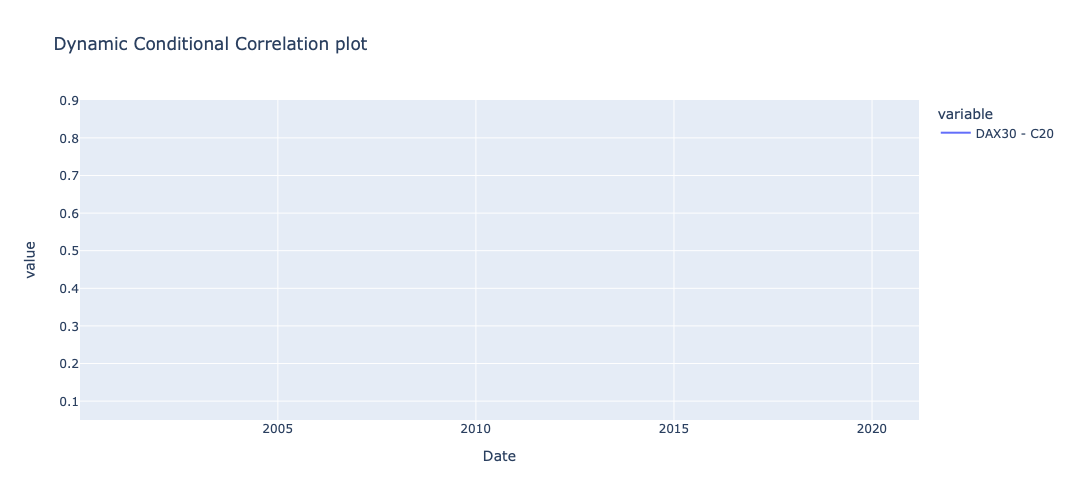

In [59]:
dcc_corr = pd.DataFrame(veclRt, index = df.loc[:,'DDAX30':'DC20'].dropna().index, columns= corr_name_list)
dcc_plot = px.line(dcc_corr, title = 'Dynamic Conditional Correlation plot', width=1000, height=500)
dcc_plot.show()

In [62]:
garch_vol_df = pd.concat([pd.DataFrame(model_parameters[x].conditional_volatility/100)*1600 for x in model_parameters], axis=1)
garch_vol_df.columns = stock_names

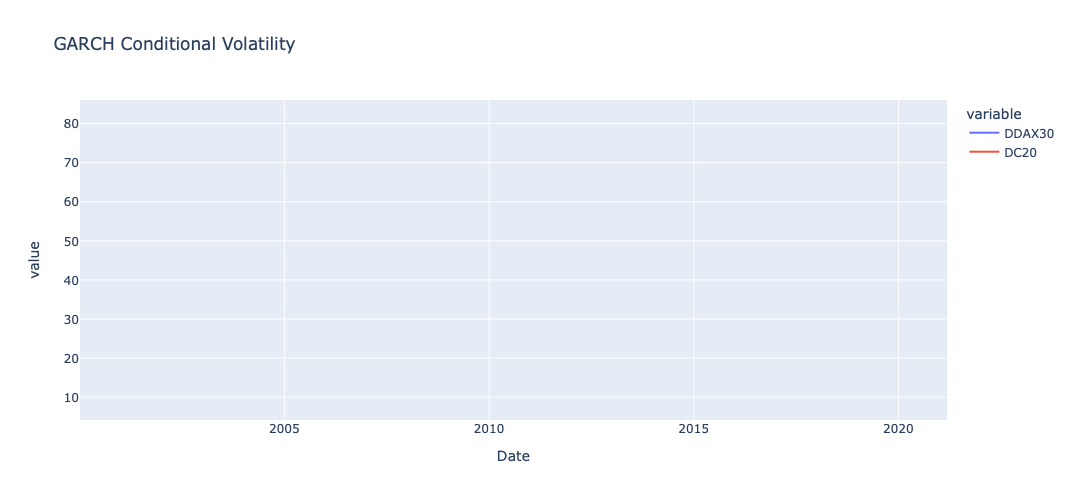

In [63]:
px.line(garch_vol_df, title='GARCH Conditional Volatility', width=1000, height=500).show()

In [ ]:
#Cumulative returns of DAX30 and C20

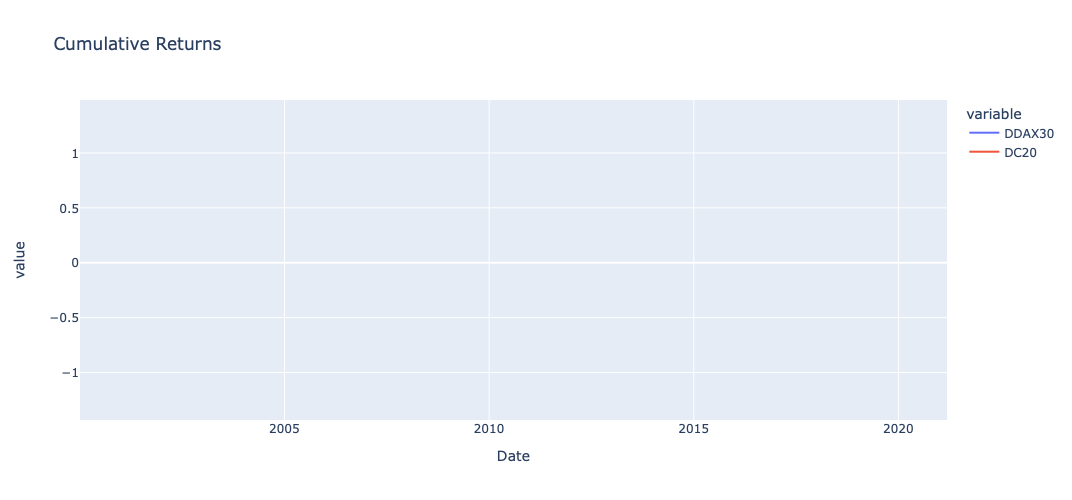

In [65]:
px.line(np.log((1+df.loc[:,'DDAX30':'DC20'].dropna()/100).cumprod()), title='Cumulative Returns', width=1000, height=500).show()

In [67]:
df.loc[:,'DDAX30':'DC20'].dropna().corr()

,DDAX30,DC20
DDAX30,1.000000,0.610161
DC20,0.610161,1.000000
